## 数据卡片 | Data Card

### 内容 | Content

输入 `weatherHistory.csv` 文件 | Input `weatherHistory.csv`

每小时响应中可用的数据：| Data available in the hourly response:

- time 时间
  - 2006-01-01 —— 2017-01-01
- summary 摘要 
  - Partly Cloudy
  - Mostly Cloudy
  - Other
- precipType 沉淀类型
  - Rain
  - Snow
  - Other
- temperature 温度 (C)
  - -21.9 —— 39.9
- apparent Temperature 体感温度 (C)
  - -27.7 —— 39.3 
- humidity 湿度
  - 0 —— 1
- windSpeed 风速 (km/h)
  - 0 —— 63.9
- windBearing 风向 (degree)
  - 0 —— 359
- visibility 能见度 (km)
  - 0 —— 16.1
- loudCover 云量
  - 0
- pressure 气压 (millibars)
  - 994.06 —— 1046.38

---

本项目是根据kaggle上`https://www.kaggle.com/datasets/budincsevity/szeged-weather`中一些项目的复现

This project is a replication of some projects from `https://www.kaggle.com/datasets/budincsevity/szeged-weather` on Kaggle

---

## 完整代码（多元线性回归）

$$\hat{y} = w_1x_1 + w_2x_2 + \cdots + w_nx_n + b$$

$\hat{y}$ - Apprent Temperature

### 准备

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('future.no_silent_downcasting', True)
import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt



In [216]:
df = pd.read_csv("weatherHistory.csv")


In [217]:
df.head(5)


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [218]:
df["Date"] = pd.to_datetime(df["Formatted Date"], utc = True)
df["Month"] = df["Date"].dt.month


In [219]:
del df["Loud Cover"], df["Formatted Date"], df["Daily Summary"], df["Date"]
# df = df.drop(["Loud Cover", "Formatted Date", "Loud Cover", "Daily Summary"], axis = 1)


按 Summary 分组，计算每组的 Apparent Temperature (C) 平均值

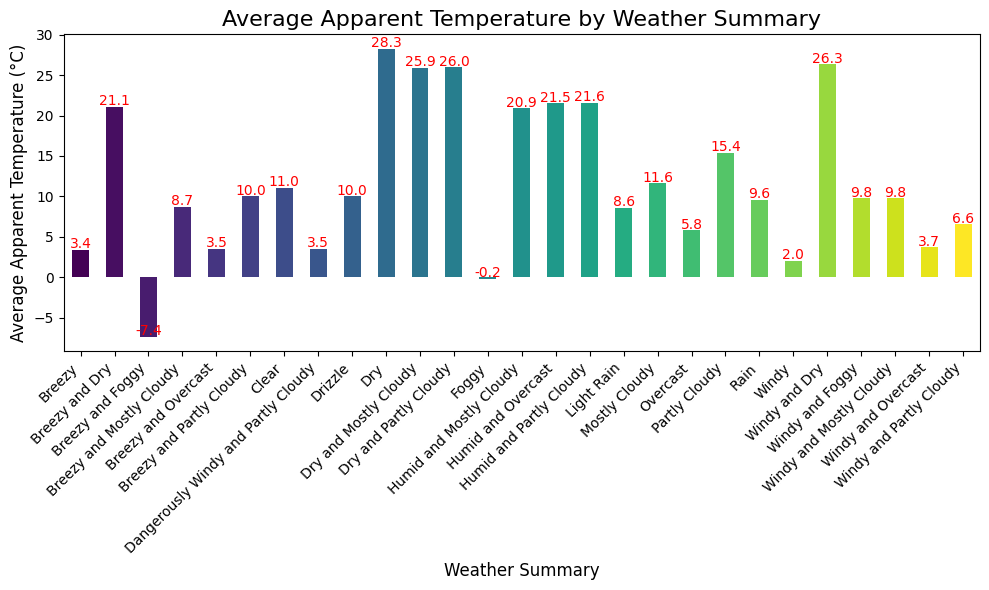

In [220]:
grouped = df.groupby("Summary")["Apparent Temperature (C)"].mean()

cmap = plt.get_cmap('viridis', len(grouped))
colors = cmap(np.linspace(0, 1, len(grouped)))

plt.figure(figsize=(10, 6))
ax = grouped.plot(kind = "bar", color = colors)

plt.title("Average Apparent Temperature by Weather Summary", fontsize = 16)
plt.xlabel("Weather Summary", fontsize = 12)
plt.ylabel("Average Apparent Temperature (°C)", fontsize = 12)
plt.xticks(rotation = 45, ha = 'right')

# Optional: Add value labels on each bar
for i, v in enumerate(grouped):
    ax.text(i, v + 0.2, f"{v:.1f}", color = "red", ha = 'center', fontsize = 10)

plt.tight_layout()
plt.show()

用 LabelEncoder 把“Summary”文本（如“Partly Cloudy”）转为数字编码。

In [221]:
label_encoder = preprocessing.LabelEncoder()
df["Summary"] = label_encoder.fit_transform(df["Summary"])


把“Precip Type”列中的“rain”替换为0，“snow”替换为1。

In [222]:
df["Precip Type"] = df["Precip Type"].replace(["rain", "snow"], [0, 1])


计算所有特征与“Apparent Temperature (C)”（体感温度）的相关系数

In [223]:
df[df.columns[:]].corr()["Apparent Temperature (C)"][:]


Summary                     0.142760
Precip Type                -0.566058
Temperature (C)             0.992629
Apparent Temperature (C)    1.000000
Humidity                   -0.602571
Wind Speed (km/h)          -0.056650
Wind Bearing (degrees)      0.029031
Visibility (km)             0.381718
Pressure (millibars)       -0.000219
Month                       0.157986
Name: Apparent Temperature (C), dtype: float64

In [224]:
df.isna().sum()

Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Pressure (millibars)          0
Month                         0
dtype: int64

把“Precip Type”中的缺失值（NaN）替换为0。

In [225]:
df["Precip Type"] = df["Precip Type"].replace(np.nan, 0)


In [226]:
df.isna().sum()


Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
Month                       0
dtype: int64

In [227]:
del df["Pressure (millibars)"]


每一列的偏度（衡量分布的对称性）。

In [228]:
for i in df.columns.values:
    print(f"{i}: {str(df[i].skew())}")


Summary: -1.6457613404719569
Precip Type: 2.4757475503013815
Temperature (C): 0.09412658235198375
Apparent Temperature (C): -0.05730229860439617
Humidity: -0.715880427565631
Wind Speed (km/h): 1.1134929678251166
Wind Bearing (degrees): -0.15464320132703985
Visibility (km): -0.4987118639375199
Month: -0.009476092809114676


In [229]:
df

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Month
0,19,0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,3
1,19,0,9.355556,7.227778,0.86,14.2646,259.0,15.8263,3
2,17,0,9.377778,9.377778,0.89,3.9284,204.0,14.9569,4
3,19,0,8.288889,5.944444,0.83,14.1036,269.0,15.8263,4
4,17,0,8.755556,6.977778,0.83,11.0446,259.0,15.8263,4
...,...,...,...,...,...,...,...,...,...
96448,19,0,26.016667,26.016667,0.43,10.9963,31.0,16.1000,9
96449,19,0,24.583333,24.583333,0.48,10.0947,20.0,15.5526,9
96450,19,0,22.038889,22.038889,0.56,8.9838,30.0,16.1000,9
96451,19,0,21.522222,21.522222,0.60,10.5294,20.0,16.1000,9


In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Summary                   96453 non-null  int64  
 1   Precip Type               96453 non-null  object 
 2   Temperature (C)           96453 non-null  float64
 3   Apparent Temperature (C)  96453 non-null  float64
 4   Humidity                  96453 non-null  float64
 5   Wind Speed (km/h)         96453 non-null  float64
 6   Wind Bearing (degrees)    96453 non-null  float64
 7   Visibility (km)           96453 non-null  float64
 8   Month                     96453 non-null  int32  
dtypes: float64(6), int32(1), int64(1), object(1)
memory usage: 6.3+ MB


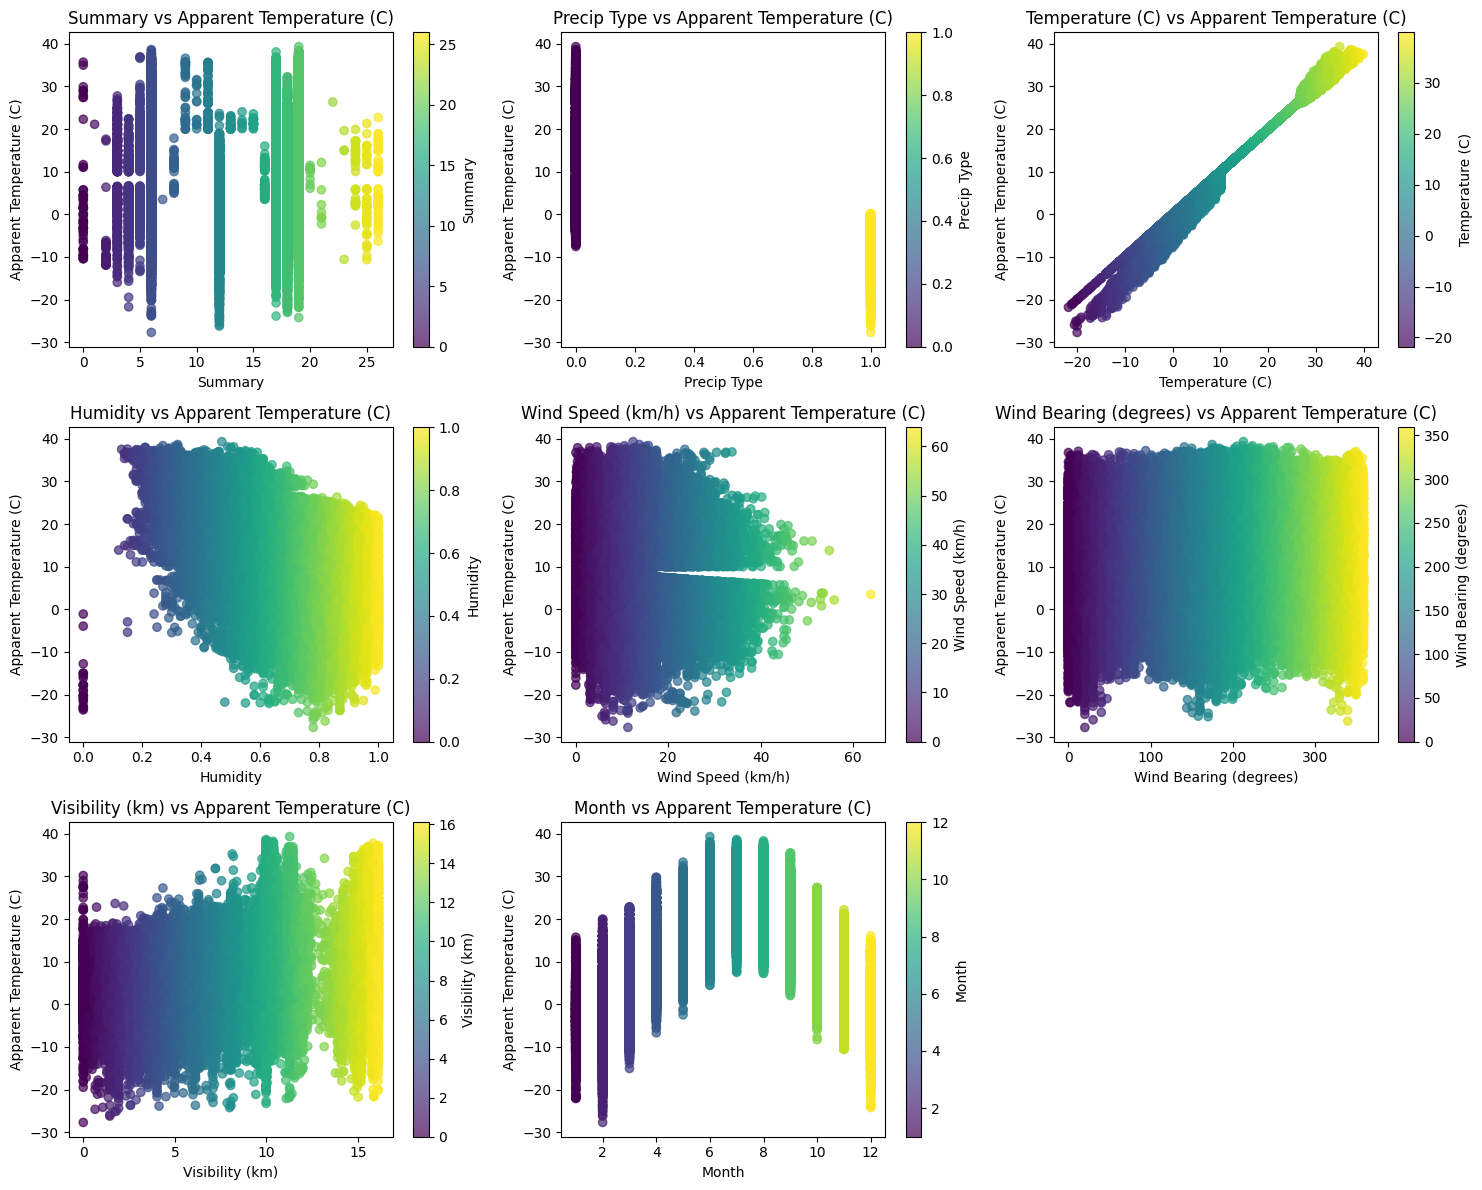

In [ ]:
feature_cols = [col for col in df.columns if col not in ["Apparent Temperature (C)"]]

n_features = len(feature_cols)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize = (5 * n_cols, 4 * n_rows))

for idx, col in enumerate(feature_cols):

    plt.subplot(n_rows, n_cols, idx + 1)

    sc = plt.scatter(
        df[col], 
        df["Apparent Temperature (C)"], 
        c = df[col],                # Use feature value for color
        cmap = "viridis", 
        alpha = 0.7
    )

    plt.title(f"{col} vs Apparent Temperature (C)")
    plt.xlabel(col)
    plt.ylabel("Apparent Temperature (C)")

    plt.colorbar(sc, label = col)
    
plt.tight_layout()
plt.show()


---
### 拟合
---

In [ ]:
target = df["Apparent Temperature (C)"]

In [ ]:
del df["Apparent Temperature (C)"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df, target, random_state = 0, test_size = 0.2
)


In [ ]:
LR = LinearRegression()
model = LR.fit(X_train, y_train)


In [ ]:
print(f"MSE: {mean_squared_error(y_test, model.predict(X_test))}")
print(f"RMSE: {sqrt(mean_squared_error(y_test, model.predict(X_test)))}")


MSE: 1.1477801100812808
RMSE: 1.0713450004929694


In [ ]:
print(f"train set score: {model.score(X_train, y_train)}")
print(f"test set score: {model.score(X_test, y_test)}")


train set score: 0.9899724050655376
test set score: 0.9898826433110118


In [ ]:
for feature, coef in zip(X_train.columns, model.coef_):
    print(f"\n {feature}: {coef:.4f}")

print(f"\n Intercept (constant): {model.intercept_:.4f}")


 Summary: -0.0062

 Precip Type: -0.4565

 Temperature (C): 1.1155

 Humidity: 0.8167

 Wind Speed (km/h): -0.0979

 Wind Bearing (degrees): 0.0005

 Visibility (km): -0.0043

 Month: 0.0027

 Intercept (constant): -1.9183


In [ ]:
equation = "y = "
terms = [f"{coef:.3f}*{feature}" for feature, coef in zip(X_train.columns, model.coef_)]
equation += " + ".join(terms)
equation += f" + {model.intercept_:.3f}"
print("Regression equation：")
print(equation)


Regression equation：
y = -0.006*Summary + -0.456*Precip Type + 1.116*Temperature (C) + 0.817*Humidity + -0.098*Wind Speed (km/h) + 0.001*Wind Bearing (degrees) + -0.004*Visibility (km) + 0.003*Month + -1.918


---

## 一些问题

作者对源数据的特征做的处理不够。
从图像可以看出，特征几乎看不出来有关联。由此导致的结果是，拟合的方程是没有说服力的。也就是说，虽然拟合出来了预测方程，但是此预测方程的泛化能力是有限的。

当然，可能源数据有问题。

修改：......